In [94]:
%matplotlib inline

In [113]:
import pandas as pd
from matplotlib import pyplot as plt

In [421]:
country='guinea'

In [422]:
df = pd.read_csv('data/previous-case-counts-%s.csv' % country)
df = df.drop(columns=['Unnamed: 0'])
df['WHO report date'] = pd.to_datetime(df['WHO report date'], format="%d/%m/%Y")
df = df.set_index('WHO report date')

In [423]:
# assume first case was this many days before first report
# affects day numbering and inferred initial rate 
dayzero = 7
df.loc[df.index.min() - pd.DateOffset(dayzero)] = 0
df = df.sort_index()

In [424]:
df = df.reset_index().rename_axis('report')
print(len(df))

266


In [425]:
# Assume that a negative delta is a revision to the previous report
def apply_revisions(df, maxit=100):
    def apply(df):
        df = df.copy()
        delta_cases = np.insert(np.diff(df['Total Cases']), 0, 0)
        delta_deaths = np.insert(np.diff(df['Total Deaths']), 0, 0)
        newdf = pd.DataFrame(columns=df.columns, dtype='int')
        current = None
        for i in range(len(df)):
            if delta_cases[i] >= 0 and delta_deaths[i] >= 0:
                if current is not None:
                    newdf = newdf.append(current)
                current = df.iloc[i].copy()
            else:
                current['Total Cases'] += delta_cases[i]
                current['Total Deaths'] += delta_deaths[i]
        newdf = newdf.append(current)
        newdf = newdf.rename_axis('report')
        return newdf
    for i in range(maxit):
        newdf = apply(df)
        change = len(df) - len(newdf)
        df = newdf
        if change == 0:
            break
    return df

In [426]:
df = apply_revisions(df)

In [427]:
print(len(df))

180


In [428]:
df = df.set_index('WHO report date')
df = df.resample('D').max()
df = df.dropna()

In [429]:
df['Delta Cases'] = np.insert(np.diff(df['Total Cases']), 0, 0)
df['Delta Deaths'] = np.insert(np.diff(df['Total Deaths']), 0, 0)

In [430]:
datezero = df.index.min()
df['Day'] = (df.index - datezero).days
df = df.sort_values('Day')

In [431]:
df['Delta Time'] = np.insert(np.diff(df['Day']), 0, 0)

In [432]:
df['Rate Cases'] = df['Delta Cases'] / df['Delta Time']
df['Rate Deaths'] = df['Delta Deaths'] / df['Delta Time']
df = df.fillna(0)

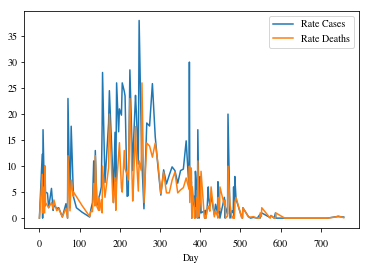

In [433]:
df.plot('Day', ['Rate Cases', 'Rate Deaths'])

In [443]:
def smooth_rates(df, index, smooth=14):
    dfs = df.drop(columns=['Total Cases', 'Total Deaths', 'Day', 
                           'Delta Cases', 'Delta Deaths', 'Delta Time'])
    daypad = smooth * 4
    dfs.loc[index.min() - pd.DateOffset(daypad)] = 0
    dfs.loc[index.max() + pd.DateOffset(1)] = np.nan
    dfs = dfs.resample('D').max()
    dfs = dfs.interpolate('linear')
    dfs = dfs.rolling(daypad, win_type='gaussian').mean(std=smooth).dropna()
    rec_cases = np.cumsum(dfs['Rate Cases'])
    rec_deaths = np.cumsum(dfs['Rate Deaths'])
    # Rescale rates
    correction = df['Total Cases'][-1] / rec_cases[-1]
    dfs['Rate Cases'] *= correction
    correction = df['Total Deaths'][-1] / rec_deaths[-1]
    dfs['Rate Deaths'] *= correction
    datezero = index.min()
    dfs['Day'] = (dfs.index - datezero).days
    dfs = dfs[dfs['Day'] >= 0]
    return dfs

In [449]:
dfs = smooth_rates(df, df.index)
nboots = 100
rate_cases = np.zeros((nboots, len(dfs)))
rate_deaths = np.zeros((nboots, len(dfs)))
for i in range(nboots):
    dfsi = smooth_rates(df.sample(len(df), replace=True).sort_index(), df.index)
    rate_cases[i] = dfsi['Rate Cases'].values
    rate_deaths[i] = dfsi['Rate Deaths'].values

In [450]:
mean = rate_cases.mean(0)
std = rate_cases.std(0)

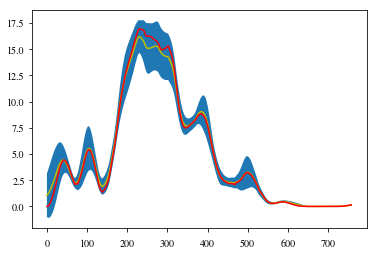

In [451]:
plt.fill_between(dfs['Day'], mean-std, mean+std)
plt.plot(dfs['Day'], mean, 'y')
plt.plot(dfs['Day'], dfs['Rate Cases'], 'r')

In [438]:
cov = np.cov(rate_cases.T)
print(cov.shape)

(759, 759)


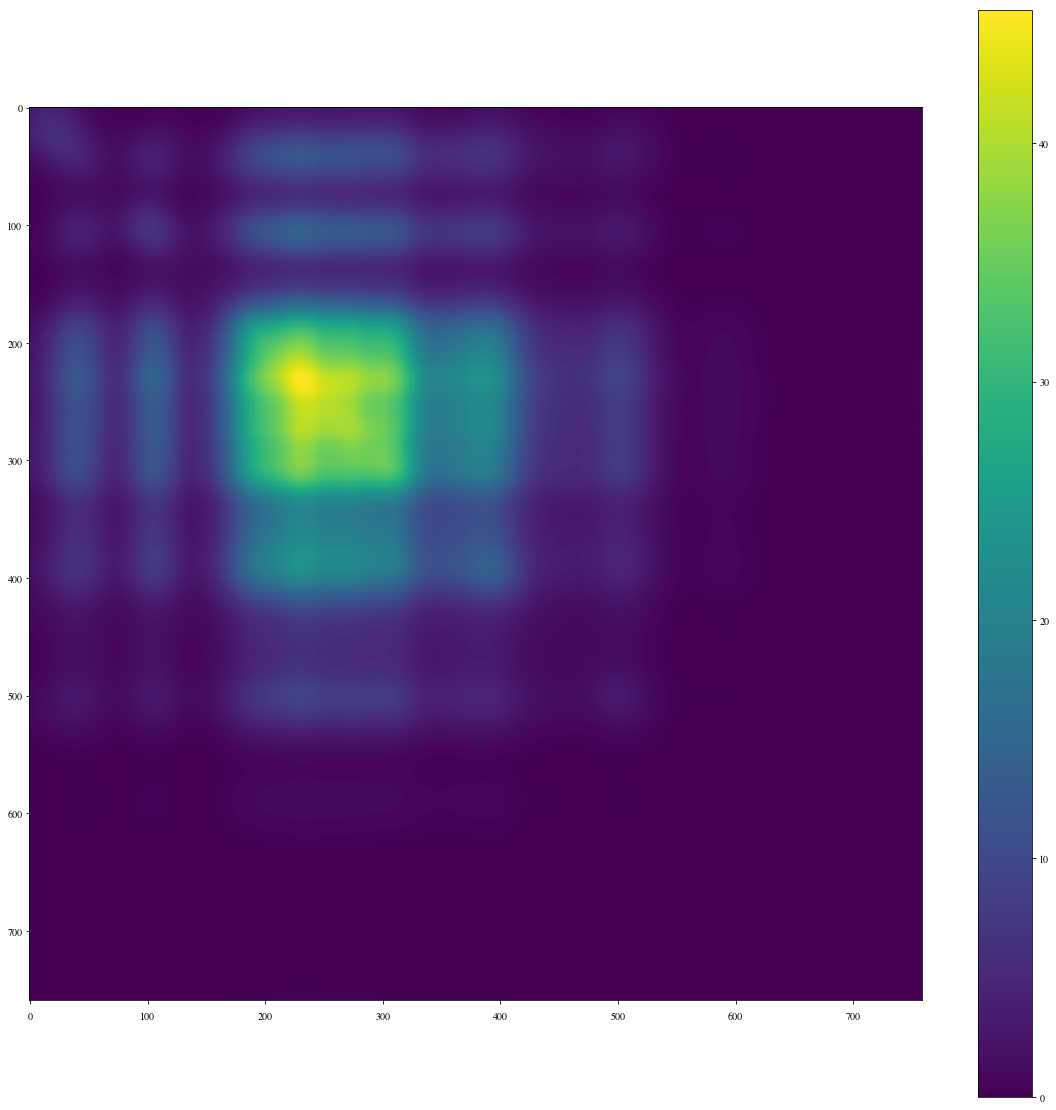

In [439]:
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(cov, interpolation='none')
plt.colorbar(im);